In [1]:
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout,Input
from tensorflow.keras.callbacks import Callback,EarlyStopping,ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
import seaborn as sns

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
CHANNELS = 3


In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/user/OneDrive/Documents/SKIN CANCER/multiple-skin-disease-detection-and-classification/Skin Cancer Dataset",
    shuffle=True, 
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4107 files belonging to 9 classes.


In [4]:
class_names = dataset.class_names
class_names

['Acitinic Keratosis',
 'Basal Cell Carcinoma',
 'Dermatofibroma',
 'Melanoma',
 'Nevus',
 'Pigmented Benign Keratosis',
 'Seborrheic Keratosis',
 'Squamous Cell Carcinoma',
 'Vascular Lesion']

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(64, 224, 224, 3)
[7 0 8 0 5 0 6 6 3 6 7 4 0 2 2 6 6 0 7 6 1 7 0 1 1 0 3 1 1 1 5 2 2 0 0 6 0
 5 0 1 8 4 2 6 0 7 5 3 5 0 1 6 2 1 3 0 3 0 1 5 7 1 0 3]


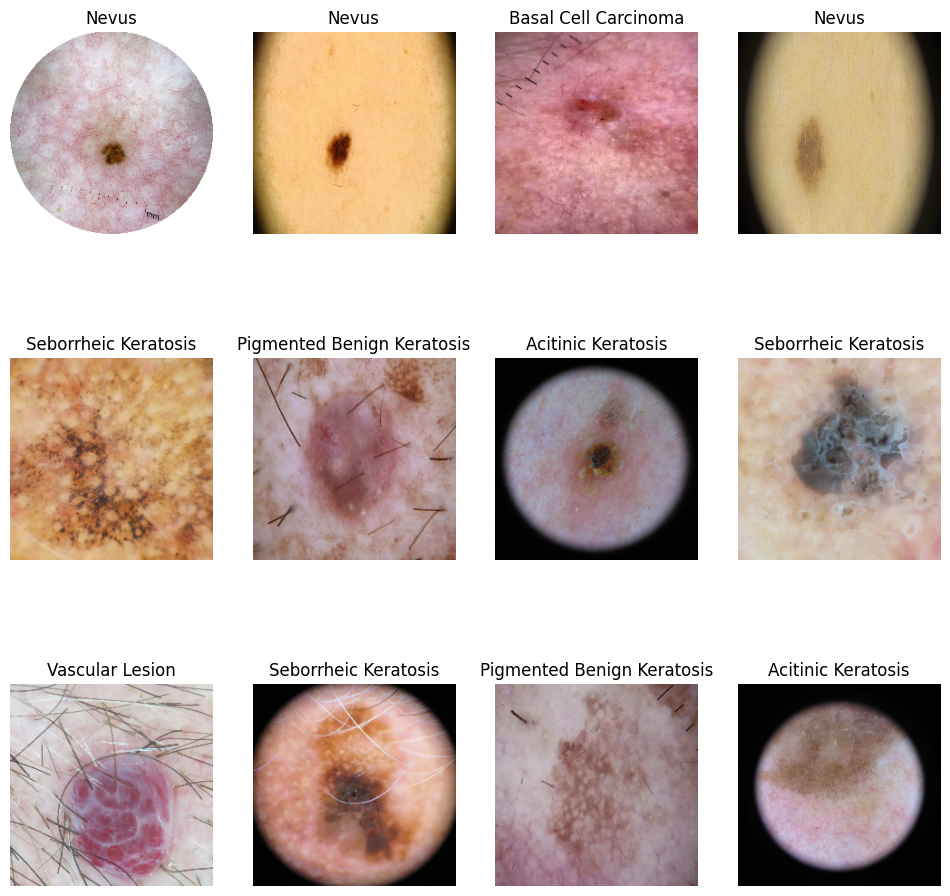

In [6]:
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
# spliting he dataset using a function
def get_datset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle= True, shuffle_size=10000):
    ds_size= len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=123)
    train_size= int(train_split* ds_size)
    val_size=int(val_split * ds_size)
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds,test_ds = get_datset_partitions_tf(dataset)

In [9]:
len(train_ds), len(val_ds), len(test_ds)

(52, 6, 7)

In [10]:
#train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE))),
    tf.keras.layers.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
   layers.RandomFlip("horizontal" or "vertical"),
   layers.RandomRotation(0.2),
   layers.RandomZoom(0.2),
   #layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  
#    layers.RandomContrast(factor=0.1),              # Adjusts contrast randomly by up to 10%
#    layers.RandomBrightness(factor=0.1) 
])

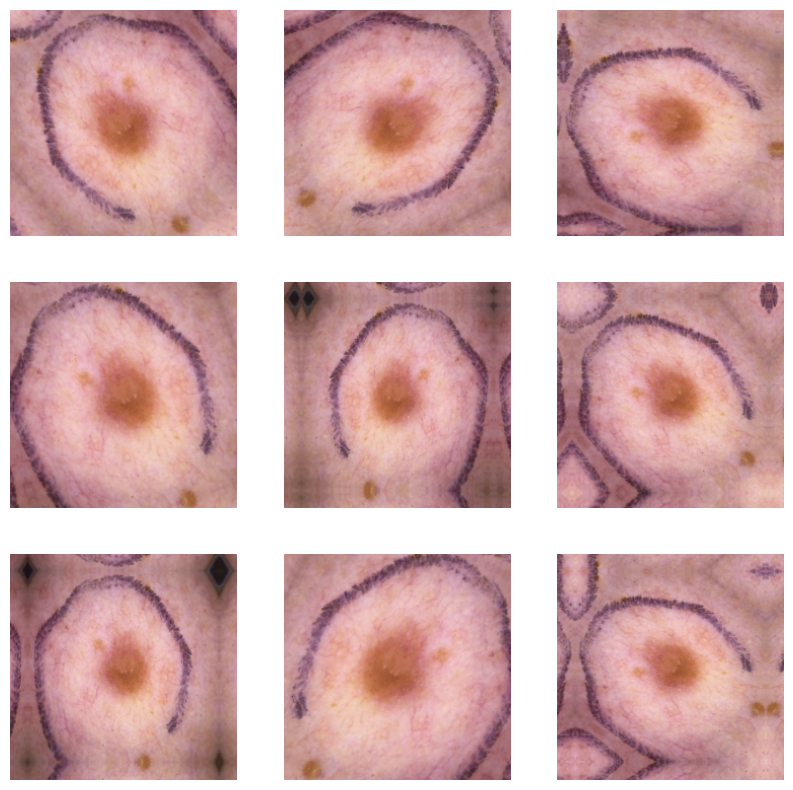

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(3):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [14]:
# from tensorflow.keras.applications import VGG16 
from tensorflow.keras.applications import EfficientNetB0, ResNet50
# Load pre-trained model 
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

# Add custom layers for fine-tuning
inputs = Input(shape=(224,224, 3))
x=resize_and_rescale(inputs)
x = data_augmentation(inputs)
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
x = Dropout(0.5)(x)  
predictions = Dense(9, activation='softmax')(x)  

# Create the final fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
from keras import optimizers
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.9, beta_2=0.999),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto', restore_best_weights=True)

In [17]:
history = model.fit(
    train_ds,
    epochs=20,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    callbacks=[early_stop]

)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 273s 5s/step - accuracy: 0.3423 - loss: 2.1457 - val_accuracy: 0.6068 - val_loss: 1.1992
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step - accuracy: 0.6715 - loss: 0.9256 - val_accuracy: 0.6927 - val_loss: 0.9602
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.7664 - loss: 0.7148 - val_accuracy: 0.7240 - val_loss: 0.8382
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.8258 - loss: 0.5330 - val_accuracy: 0.7109 - val_loss: 0.7692
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 236s 5s/step - accuracy: 0.8578 - loss: 0.4177 - val_accuracy: 0.7969 - val_loss: 0.6771
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 243s 5s/step - accuracy: 0.8740 - loss: 0.3520 - val_accuracy: 0.7995 - val_loss: 0.6251
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.9112 - loss: 0.2783 - val_accuracy: 0.8229 - val_loss: 0.6315
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 244s 5s/step - accuracy: 0.9332 - loss: 0.2322 - val_accuracy: 0.8125 - v

## evaluation

### test data

In [18]:
import numpy as np
y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
    predictions = model.predict(image_batch)
    predicted_labels = np.argmax(predictions, axis=-1)
    y_pred.extend(predicted_labels)
    y_true.extend(label_batch.numpy())


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [19]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Print shapes to verify
print("Predicted labels shape:", y_pred.shape)
print("True labels shape:", y_true.shape)


Predicted labels shape: (395,)
True labels shape: (395,)


In [20]:
from sklearn.metrics import classification_report, accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8632911392405064


In [21]:
# Print classification report
#class_names = ["nevus", "melanoma", "squamous cell carcinoma", "basal cell carcinoma", "actinic keratosis", "vascular lesion", "dermatofibroma", "seborrheic keratosis", "pigmented benign keratosis"]
print(classification_report(y_true, y_pred, target_names=class_names))

                            precision    recall  f1-score   support

        Acitinic Keratosis       0.91      0.90      0.91        48
      Basal Cell Carcinoma       0.86      0.78      0.82        49
            Dermatofibroma       0.89      0.93      0.91        27
                  Melanoma       0.78      0.86      0.82        50
                     Nevus       0.87      0.94      0.90        49
Pigmented Benign Keratosis       0.88      0.87      0.87        52
      Seborrheic Keratosis       0.85      0.75      0.80        69
   Squamous Cell Carcinoma       0.83      0.93      0.88        27
           Vascular Lesion       0.92      1.00      0.96        24

                  accuracy                           0.86       395
                 macro avg       0.87      0.88      0.87       395
              weighted avg       0.86      0.86      0.86       395



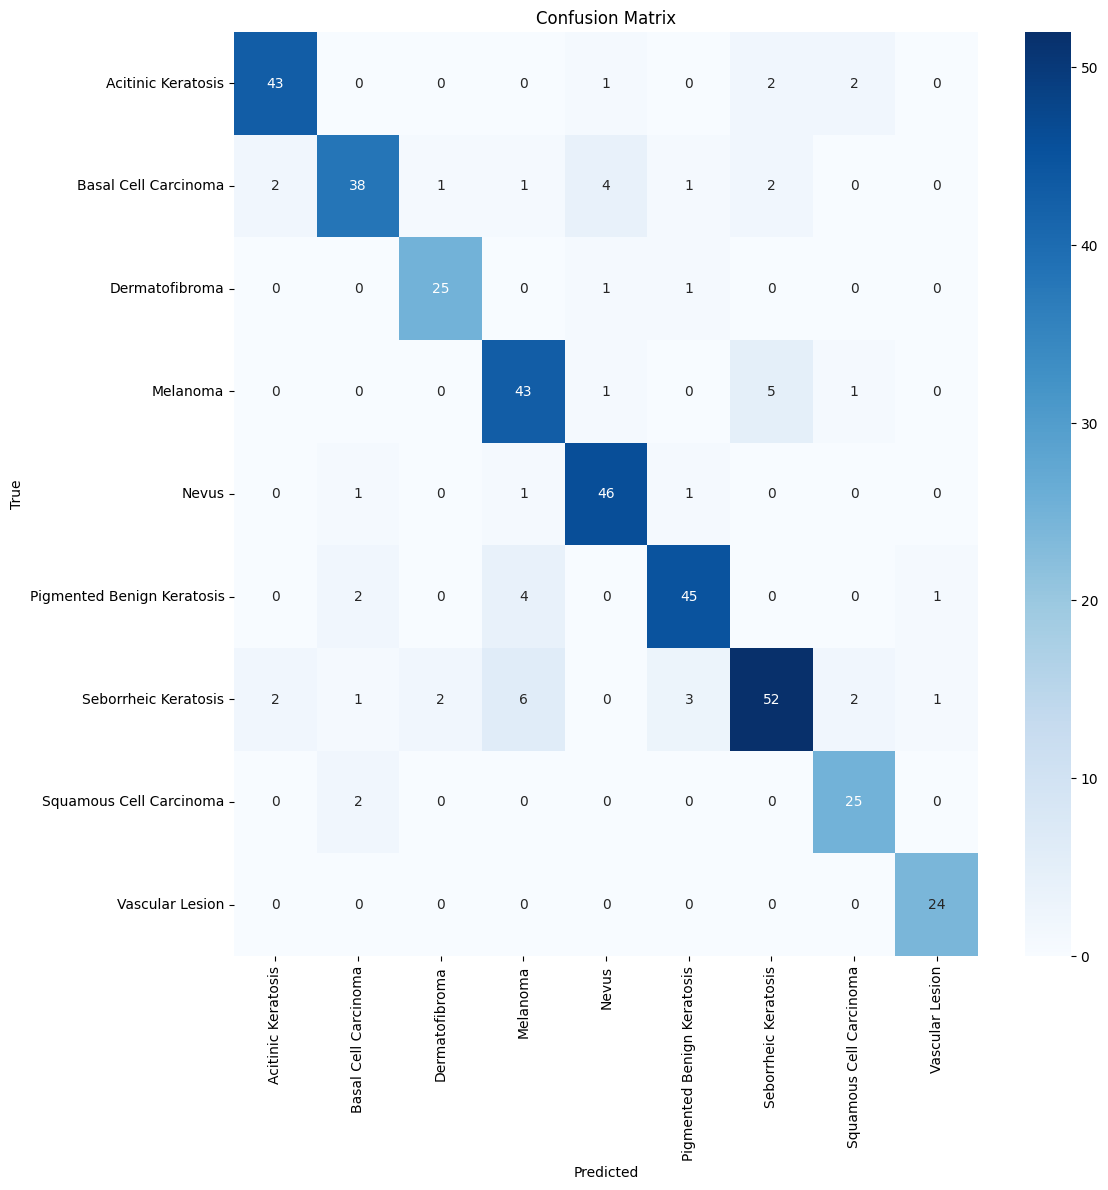

In [22]:
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### validation data

In [33]:
import numpy as np
y_pred_val = []
y_true_val = []

for image_batch, label_batch in val_ds:
    predictions1 = model.predict(image_batch)
    predicted_labels1 = np.argmax(predictions1, axis=-1)
    y_pred_val.extend(predicted_labels1)
    y_true_val.extend(label_batch.numpy())

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


In [34]:
from sklearn.metrics import classification_report, accuracy_score
accuracy = accuracy_score(y_true_val, y_pred_val)
print("Accuracy:", accuracy)

Accuracy: 0.875


In [35]:
print(classification_report(y_true_val, y_pred_val, target_names=class_names))

                            precision    recall  f1-score   support

        Acitinic Keratosis       0.88      0.90      0.89        42
      Basal Cell Carcinoma       0.81      0.81      0.81        43
            Dermatofibroma       0.92      0.90      0.91        40
                  Melanoma       0.87      0.85      0.86        48
                     Nevus       0.92      0.96      0.94        49
Pigmented Benign Keratosis       0.88      0.96      0.92        47
      Seborrheic Keratosis       0.81      0.76      0.79        46
   Squamous Cell Carcinoma       0.82      0.80      0.81        35
           Vascular Lesion       0.94      0.91      0.93        34

                  accuracy                           0.88       384
                 macro avg       0.87      0.87      0.87       384
              weighted avg       0.87      0.88      0.87       384



In [37]:
model.save('skin_lesion_model.keras')